In [1]:
%load_ext tensorboard
!rm -rf ./logs/

import pandas as pd
import swifter
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import re

import spacy_udpipe

from nltk.tokenize import TweetTokenizer

import time
import os

/home/alexkay/anaconda3/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
data = pd.read_csv('lemmatized_train.csv')
data = data.dropna()
data.head(4)

,tweet,class
0,depression_NOUN hurts_NOUN cymbalta_NOUN can_A...,0
1,right_INTJ but_CCONJ cipro_NOUN can_AUX make_V...,0
2,be_AUX you_PRON paxil_NOUN I_PRON need_VERB he...,0
3,lamotrigine_NOUN and_CCONJ sj_NOUN just_ADV ma...,0


In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(data['tweet'], data['class'], test_size=0.06)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((4839,), (4839,), (309,), (309,))

# Tokenize data

In [4]:
num_words = 10_000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

x_train = tokenizer.texts_to_sequences(X_train)
x_test  = tokenizer.texts_to_sequences(X_test)

max_len = max(max([len(el) for el in x_train]), max([len(el) for el in x_test]))

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)
x_test  = tf.keras.preprocessing.sequence.pad_sequences(x_test,  maxlen=max_len)

num_classes = 2
y_train = tf.keras.utils.to_categorical(Y_train, num_classes=num_classes)
y_test  = tf.keras.utils.to_categorical(Y_test, num_classes=num_classes)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4839, 62), (4839, 2), (309, 62), (309, 2))

In [5]:
BATCH_SIZE, BUF_SIZE = 128, 3000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(BUF_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.padded_batch(BATCH_SIZE, drop_remainder=True)

train_dataset, test_dataset

(<PaddedBatchDataset shapes: ((128, 62), (128, 2)), types: (tf.int32, tf.float32)>,
 <PaddedBatchDataset shapes: ((128, 62), (128, 2)), types: (tf.int32, tf.float32)>)

# Model

In [6]:
embedding_dim = 256
num_words = num_words


class MyModel(tf.keras.Model):
    
    def __init__(self, num_words, embedding_dim):
        super(MyModel, self).__init__()

        self.emb = tf.keras.layers.Embedding(num_words, embedding_dim)
        self.conv = tf.keras.layers.Conv1D(10, 3, activation='relu')
        self.lstm = tf.keras.layers.LSTM(128)
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(32, activation='relu')
        self.out = tf.keras.layers.Dense(2, activation='softmax')
        
    def call(self, inputs, training_mode=True):
        x = self.emb(inputs)
        x = self.conv(x)
        x = self.lstm(x)
        x = self.dense1(x)
        x = self.dense2(x)
        out = self.out(x)
        return out
    
model = MyModel(num_words, embedding_dim)

# TenorBoard

In [7]:
import datetime

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

# LR schedule

Text(0.5, 0, 'Train Step')

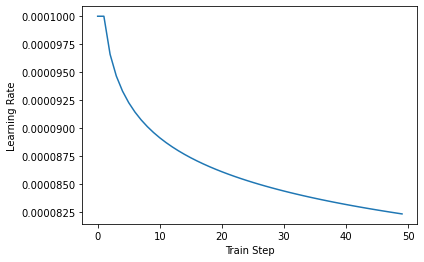

In [8]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps=5):
        super(CustomSchedule, self).__init__()

    def __call__(self, step):
        minimal = 1e-4
        #return tf.math.maximum(0.001 - 0.000001 * step, 0.0001)
        return tf.math.minimum(minimal/step**0.05, minimal)
        
learning_rate = CustomSchedule()

plt.plot(learning_rate(tf.range(50, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Loss, Opt, Steps

In [9]:
loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)

train_loss = tf.keras.metrics.Mean(name='TrainL')
train_acc = tfa.metrics.F1Score(2, name='TrainF1')
test_loss = tf.keras.metrics.Mean(name='TestL')
test_acc = tfa.metrics.F1Score(2, name='TestF1')

In [10]:
@tf.function
def train_step(values, labels):
    print('creating train step!')
    with tf.GradientTape() as tape:
        predictions = model(values)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_acc(labels, predictions)
    
@tf.function
def test_step(values, labels):
    print('creating test step!')
    predictions = model(values)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_acc(labels, predictions)

# Train loop

In [12]:
%tensorboard --logdir logs

EPOCHS = 100
pat, PATIENCE_MAX, best = 0, 5, 0

f1test = []

for epoch in range(EPOCHS):
    
    total_loss_train, total_acc_train = 0, 0
    total_loss_test,  total_acc_test  = 0, 0
    
    batch_counter1, batch_counter2 = 0, 0
    
    #print(f'Epoch:{epoch}/{EPOCHS}\n')
    for batch, (train_tweet, train_label) in enumerate(train_dataset):
        train_step(train_tweet, train_label)
        s_loss = train_loss.result()
        total_loss_train += train_loss.result()
        batch_counter1 += 1
        if batch % 2 == 0:
            print(f'TRAIN: epoch:{epoch} batch:{batch} loss:{s_loss:.4f}', end='\r')
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', total_loss_train, step=epoch)
        tf.summary.scalar('f1_score', sum(train_acc.result())/2, step=epoch)
            
    for batch, (test_tweet, test_label) in enumerate(test_dataset):
        test_step(test_tweet, test_label)
        s_loss = test_loss.result()
        total_loss_test += test_loss.result()
        batch_counter2 += 1
        if batch % 2 == 0:
            print(f'TEST: epoch:{epoch} batch:{batch} loss:{s_loss:.4f}', end='\r')
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', total_loss_test, step=epoch)
        tf.summary.scalar('f1_score', sum(test_acc.result())/2, step=epoch)

    trainL = total_loss_train/batch_counter1
    trainA = sum(train_acc.result())/2
    testL = total_loss_train/batch_counter2
    testA = sum(test_acc.result())/2
    f1test.append(testA)
    
    if  epoch % 2 == 0:
        print(f'EPOCH:{epoch}/{EPOCHS} loss:{trainL:.4f} f1:{trainA:.4f} val_loss:{testL:.4f} val_f1:{testA:.4f}')
     
    if epoch > 1 and best >= f1test[-1]:
        pat += 1
        if pat >= PATIENCE_MAX:
            print('\nPatience counter was exceeded...!')
            print(f'Last epoch:{epoch} with best f1-score = {best}')
            break
    else:
        best = f1test[-1]
        pat = 0
    
print(f'Best f1-score = {best}')

Reusing TensorBoard on port 6006 (pid 32217), started 0:42:25 ago. (Use '!kill 32217' to kill it.)

EPOCH:0/100 loss:0.6919 f1:0.5652 val_loss:12.8008 val_f1:0.6347
EPOCH:2/100 loss:0.6783 f1:0.6031 val_loss:12.5489 val_f1:0.6385
EPOCH:4/100 loss:0.6520 f1:0.6374 val_loss:12.0620 val_f1:0.6587
EPOCH:6/100 loss:0.5964 f1:0.6865 val_loss:11.0336 val_f1:0.7025
EPOCH:8/100 loss:0.5361 f1:0.7255 val_loss:9.9187 val_f1:0.7285
EPOCH:10/100 loss:0.4831 f1:0.7578 val_loss:8.9373 val_f1:0.7492
EPOCH:12/100 loss:0.4382 f1:0.7834 val_loss:8.1073 val_f1:0.7638
EPOCH:14/100 loss:0.4010 f1:0.8041 val_loss:7.4190 val_f1:0.7705
EPOCH:16/100 loss:0.3696 f1:0.8208 val_loss:6.8369 val_f1:0.7764
EPOCH:18/100 loss:0.3433 f1:0.8347 val_loss:6.3506 val_f1:0.7792
EPOCH:20/100 loss:0.3202 f1:0.8464 val_loss:5.9239 val_f1:0.7820
EPOCH:22/100 loss:0.3007 f1:0.8564 val_loss:5.5630 val_f1:0.7846
EPOCH:24/100 loss:0.2831 f1:0.8652 val_loss:5.2369 val_f1:0.7866
EPOCH:26/100 loss:0.2676 f1:0.8729 val_loss:4.9508 val_f1:0.7875
EPOCH:28/100 loss:0.2536 f1:0.8798 val_loss:4.6912 val_f1:0.7877
EPOCH:30/100 loss:0.2413 f